In [ ]:
'''
Credit: https://github.com/bsinghpratap/roberta_train_goEmotion/blob/master/goEmotions.ipynb
'''

'\nCredit: https://github.com/bsinghpratap/roberta_train_goEmotion/blob/master/goEmotions.ipynb\n'

In [ ]:
!pip install torch
!pip install jsonlines
!pip install numpy
!pip install transformers
!pip install pandas
!pip install tqdm
!pip install datasets
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!pip install widgetsnbextension
!jupyter nbextension enable widgetsnbextension --py --sys-prefix
!pip install seaborn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!nvidia-smi

Mon Jul  1 12:26:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 6000                Off |   00000000:1B:00.0 Off |                  Off |
| 33%   34C    P8             22W /  260W |    2271MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    print('Not connected to a TPU runtime')

2024-06-30 11:58:39.307930: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 11:58:39.355191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 11:58:40.087196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
Not connected to a TPU runtime


2024-06-30 11:58:40.911342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# !export CUDA_VISIBLE_DEVICES=0
# !python goEmotions.ipynb

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# import matplotlib.backends
# import multiprocessing as mp
#import matplotlib.pyplot as plt
import torch
import jsonlines
import numpy as np
import transformers
import pandas as pd
import pickle as pkl
from torch import nn
import seaborn as sns
from tqdm import tqdm
from os.path import join
from importlib import reload
from collections import Counter
import plotly.graph_objects as go
from datasets import load_dataset
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from transformers import (WEIGHTS_NAME,
                          BertConfig, BertForSequenceClassification, BertTokenizer,
                          XLMConfig, XLMForSequenceClassification, XLMTokenizer,
                          DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import BertPreTrainedModel, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel

In [ ]:
class emotionDataset(Dataset):
    """Class to load the dataset and get batches of paras"""

    def __init__(self, list_data,
                 tokenizer, max_length):

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = list_data
        self.pad_token = 1

    def __len__(self):
        """Return length of dataset."""
        return self.data.__len__()

    def __getitem__(self, i):
        """Return sample from dataset at index i."""
        example = self.data[i]
        inputs = self.tokenizer.encode_plus(example['text'],
                                            add_special_tokens=True,
                                            truncation=True,
                                            max_length=self.max_length)

        input_ids = inputs["input_ids"]
        input_ids = input_ids[:self.max_length]
        attention_mask = [1] * len(input_ids)

        padding_length = self.max_length - len(input_ids)
        input_ids = input_ids + ([self.pad_token] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)

        assert len(input_ids) == self.max_length, "Error with input length {} vs {}".format(len(input_ids), self.max_length)

        nli_label = example['labels'][0]

        return_dict = {'input_ids':torch.LongTensor(input_ids),
                       'attention_mask':torch.LongTensor(attention_mask),
                       'labels': torch.LongTensor([nli_label])}

        return return_dict

In [ ]:
id2label = {0:"admiration",
            1:"amusement",
            2:"anger",
            3:"annoyance",
            4:"approval",
            5:"caring",
            6:"confusion",
            7:"curiosity",
            8:"desire",
            9:"disappointment",
            10:"disapproval",
            11:"disgust",
            12:"embarrassment",
            13:"excitement",
            14:"fear",
            15:"gratitude",
            16:"grief",
            17:"joy",
            18:"love",
            19:"nervousness",
            20:"optimism",
            21:"pride",
            22:"realization",
            23:"relief",
            24:"remorse",
            25:"sadness",
            26:"surprise",
            27:"neutral"}

In [ ]:
dataset = load_dataset("go_emotions", "simplified")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
Counter([x['labels'].__len__() for x in dataset['train']])

Counter({1: 36308, 2: 6541, 3: 532, 4: 28, 5: 1})

In [ ]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [ ]:
dataset['train'][0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [27],
 'id': 'eebbqej'}

In [ ]:
roberta_config = RobertaConfig.from_pretrained('roberta-base',
                                      num_labels=len(id2label),
                                      finetuning_task='GoEmotions',
                                      cache_dir=None,
                                      output_attentions=False,
                                      output_hidden_states=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
train_dataset = emotionDataset(list_data=dataset['train'],
                               tokenizer=tokenizer,
                               max_length=200)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Add num_workers=2 at the end for single gpu for some reason #

In [ ]:
example_batch = next(iter(train_loader))

In [ ]:
example_batch['input_ids'].shape, example_batch['attention_mask'].shape, example_batch['labels'].shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([32, 1]))

In [ ]:
args = {'weight_decay':0.0,
        'learning_rate':2e-5,
        'epochs':15, ##### Might have to change based on performance (Original was 5)###
        'gradient_accumulation_steps':1,
        'adam_epsilon':1e-8}
args['t_total'] = len(train_loader) // args['gradient_accumulation_steps'] * args['epochs']
args['warmup_steps'] = int(0.10*args['t_total'])

In [ ]:
model = RobertaForSequenceClassification(config=roberta_config).to(device)

NameError: name 'device' is not defined

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'],
                                            num_training_steps=args['t_total'])

/ssddata/home/mmv5513/colabenv/lib64/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
###Use to train in x gpu's else DO NOT RUN###

gpu_ids = [0, 1, 2]  # Use the first x GPUs

if torch.cuda.device_count() > 1:
    print(f"Let's use GPUs: {gpu_ids}")
    model = nn.DataParallel(model, device_ids=gpu_ids)

model.to('cuda')

for i in gpu_ids:
    print(f"Using device: {i}, {torch.cuda.get_device_name(i)}")

Let's use GPUs: [0, 1, 2]
Using device: 0, Quadro RTX 6000
Using device: 1, Quadro RTX 6000
Using device: 2, Quadro RTX 6000


In [ ]:
##Single gpu wordking

# model.train()
# loss_values = []
# for each_epoch in range(args['epochs']):
#     epoch_loss = 0
#     for batch in tqdm(train_loader):
#         batch = {k: v.to(device) for k, v in batch.items()}

#         model.zero_grad()
#         outputs = model(**batch)
#         loss = outputs[0].mean()

#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         epoch_loss += loss.item()
#     avg_epoch_loss = epoch_loss / len(train_loader)
#     loss_values.append(avg_epoch_loss)
#     print(f'Epoch {each_epoch + 1}/{args["epochs"]}, Loss: {avg_epoch_loss}')

#     if avg_loss <= 0.2:
#         print("Target loss reached. Stopping training.")
#         break

# print("Training complete. Loss values for each epoch:")
# print(loss_values)

In [ ]:
model.train()
loss_values = []
for each_epoch in range(args['epochs']):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        model.zero_grad()
        outputs = model(**batch)
        loss = outputs[0].mean()

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)
    print(f'Epoch {each_epoch + 1}/{args["epochs"]}, Loss: {avg_epoch_loss}')

    if avg_epoch_loss <= 0.2:
        print("Target loss reached. Stopping training.")
        break

print("Training complete. Loss values for each epoch:")
print(loss_values)

  0%|                                                                                                       | 0/1357 [00:00<?, ?it/s]2024-07-01 12:29:33.634646: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 12:29:33.675272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 12:29:34.453035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/ssddata/home/mmv5513/colabenv/lib64/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was ask

Epoch 1/15, Loss: 2.6649455091227656


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:17<00:00,  4.28it/s]


Epoch 2/15, Loss: 2.0568467925907323


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.28it/s]


Epoch 3/15, Loss: 1.733396385466253


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:17<00:00,  4.28it/s]


Epoch 4/15, Loss: 1.5081802824005628


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:17<00:00,  4.28it/s]


Epoch 5/15, Loss: 1.3113519190072838


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:17<00:00,  4.28it/s]


Epoch 6/15, Loss: 1.12503590141049


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:17<00:00,  4.28it/s]


Epoch 7/15, Loss: 0.9551877423341255


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]


Epoch 8/15, Loss: 0.8069602526016066


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.28it/s]


Epoch 9/15, Loss: 0.6696483990727933


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]


Epoch 10/15, Loss: 0.5655123034249181


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]


Epoch 11/15, Loss: 0.4732718271043429


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]


Epoch 12/15, Loss: 0.39842017214023284


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]


Epoch 13/15, Loss: 0.34082624927854926


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]


Epoch 14/15, Loss: 0.2955866639358908


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [05:16<00:00,  4.29it/s]

Epoch 15/15, Loss: 0.2631271988477396
Training complete. Loss values for each epoch:
[2.6649455091227656, 2.0568467925907323, 1.733396385466253, 1.5081802824005628, 1.3113519190072838, 1.12503590141049, 0.9551877423341255, 0.8069602526016066, 0.6696483990727933, 0.5655123034249181, 0.4732718271043429, 0.39842017214023284, 0.34082624927854926, 0.2955866639358908, 0.2631271988477396]


I had issues running ploting code so I took screenshots and graphed it in a different spot

Training complete. Loss values for each epoch:
[2.6649455091227656, 2.0568467925907323, 1.733396385466253, 1.5081802824005628, 1.3113519190072838, 1.12503590141049, 0.9551877423341255, 0.8069602526016066, 0.6696483990727933, 0.5655123034249181, 0.4732718271043429, 0.39842017214023284, 0.34082624927854926, 0.2955866639358908, 0.2631271988477396]
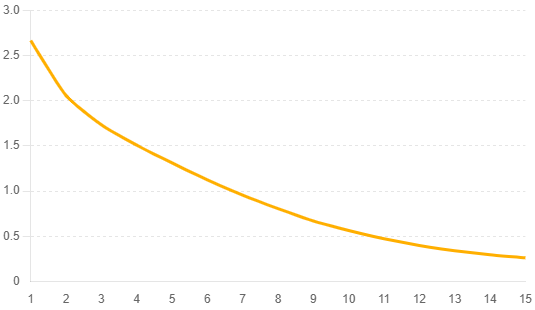

In [ ]:
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
#####################################################################                    MODEL TRAINING DONE                     #####################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################

In [ ]:
# model = model.module
# model.push_to_hub("MattViana/GoBerta", use_auth_token=" ----- ")
# tokenizer.push_to_hub("MattViana/GoBerta", use_auth_token=" ----- ")

/ssddata/home/mmv5513/colabenv/lib64/python3.9/site-packages/transformers/utils/hub.py:875: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.93k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/MattViana/GoBerta/commit/969561483dfc938a04aa09461dbee8ced9bec4b6', commit_message='Upload tokenizer', commit_description='', oid='969561483dfc938a04aa09461dbee8ced9bec4b6', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
'''
Load Model from huggingface for testing
'''
model = RobertaForSequenceClassification.from_pretrained("MattViana/GoBerta")
tokenizer = RobertaTokenizer.from_pretrained("MattViana/GoBerta")

config.json:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

In [ ]:
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################
######################################################################################################################################################################################

In [ ]:
test_dataset = emotionDataset(list_data=dataset['test'],
                               tokenizer=tokenizer,
                               max_length=200)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False)

In [ ]:
def evaluate(model_, eval_loader):
    model.eval()
    dict_result = {'actual':[],
                   'preds':[]}
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            outputs = model(**batch)
            logits = outputs[1]

            dict_result['actual'] += batch['labels'].numpy().tolist()
            dict_result['preds'] += np.argmax(logits.detach().cpu().numpy(), axis=1).tolist()
    return dict_result

In [ ]:
dict_test_results = evaluate(model_=model,
                             eval_loader=test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [02:33<00:00,  1.11it/s]


In [ ]:
def get_performance(actual_og, preds_og, dict_mapping, avoid_labels=[]):
    actual_og = [x[0] for x in actual_og]
    actual_ = []
    preds_ = []
    for ind in tqdm(range(len(actual_og))):
        if actual_og[ind] not in avoid_labels and preds_og[ind] not in avoid_labels:
            actual_.append(actual_og[ind])
            preds_.append(preds_og[ind])
    df_report = classification_report(actual_, preds_)

    print("Classification Report:")
    print(df_report)
    print("\n" + "--"*20)
    print("Summary Statistics")
    print("--"*20)
    print(f"Actual class distribution: {Counter(actual_)}")
    print(f"Predicted class distribution: {Counter(preds_)}")
    print(f"Class label mapping: {dict_mapping}")

    return df_report

In [ ]:
print("Evaluating on the full test set:")
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label)

Evaluating on the full test set:


100%|███████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [00:00<00:00, 2338451.59it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.57      0.56       504
           1       0.69      0.75      0.72       252
           2       0.34      0.33      0.34       197
           3       0.17      0.19      0.18       286
           4       0.24      0.21      0.23       318
           5       0.32      0.25      0.28       114
           6       0.32      0.32      0.32       139
           7       0.40      0.40      0.40       233
           8       0.35      0.24      0.29        74
           9       0.18      0.17      0.17       127
          10       0.21      0.20      0.20       220
          11       0.41      0.39      0.40        84
          12       0.34      0.33      0.34        30
          13       0.33      0.32      0.33        84
          14       0.64      0.51      0.57        74
          15       0.79      0.81      0.80       288
          16       0.00      0.00      0.00         6
    

In [ ]:
print("\nEvaluating with some labels excluded (labels: [12, 16, 19, 21, 23, 24]):")
df_test_excluded = get_performance(actual_og=dict_test_results['actual'],
                                   preds_og=dict_test_results['preds'],
                                   dict_mapping=id2label,
                                   avoid_labels=[12, 16, 19, 21, 23, 24])


Evaluating with some labels excluded (labels: [12, 16, 19, 21, 23, 24]):


100%|███████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [00:00<00:00, 1782497.09it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       502
           1       0.69      0.76      0.72       251
           2       0.35      0.33      0.34       195
           3       0.18      0.19      0.18       282
           4       0.25      0.22      0.23       316
           5       0.32      0.26      0.28       113
           6       0.32      0.33      0.32       138
           7       0.40      0.40      0.40       231
           8       0.35      0.25      0.29        73
           9       0.18      0.17      0.17       125
          10       0.22      0.20      0.21       216
          11       0.42      0.40      0.41        83
          13       0.33      0.32      0.33        84
          14       0.66      0.54      0.59        71
          15       0.79      0.81      0.80       286
          17       0.43      0.43      0.43       115
          18       0.58      0.63      0.60       169
    

In [ ]:
print("\nEvaluating with more labels excluded (labels: [8, 11, 12, 13, 14, 16, 19, 21, 23, 24, 26]):")
df_test_excluded_more = get_performance(actual_og=dict_test_results['actual'],
                                        preds_og=dict_test_results['preds'],
                                        dict_mapping=id2label,
                                        avoid_labels=[8, 11, 12, 13, 14, 16, 19, 21, 23, 24, 26])


Evaluating with more labels excluded (labels: [8, 11, 12, 13, 14, 16, 19, 21, 23, 24, 26]):


100%|███████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [00:00<00:00, 1581277.37it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       486
           1       0.71      0.77      0.74       247
           2       0.37      0.35      0.36       187
           3       0.19      0.20      0.20       265
           4       0.26      0.22      0.24       308
           5       0.33      0.26      0.29       110
           6       0.33      0.33      0.33       135
           7       0.42      0.43      0.42       217
           9       0.20      0.18      0.19       118
          10       0.23      0.21      0.22       202
          15       0.81      0.83      0.82       281
          17       0.47      0.44      0.45       111
          18       0.60      0.64      0.62       166
          20       0.47      0.45      0.46       113
          22       0.20      0.17      0.18        96
          25       0.47      0.40      0.43        96
          27       0.55      0.58      0.56      1543

   